In [354]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import glob
from scipy import stats
import datetime as dt

In [355]:
ACC = pd.read_csv('46343_acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('46343_heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('46343_labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [356]:
ACC

timedelta      accX      accY      accZ
0      -124489.161050  0.017487 -0.586700 -0.805771
1      -124489.116395  0.018982 -0.589676 -0.809158
2      -124489.115548  0.020966 -0.580887 -0.815048
3      -124489.114691  0.019485 -0.580872 -0.813583
4      -124489.097700  0.016998 -0.587204 -0.806259
...               ...       ...       ...       ...
981995   17642.967007  0.505249  0.425720 -0.748764
981996   17642.987576  0.508194  0.429138 -0.750717
981997   17643.006946  0.508179  0.427200 -0.747284
981998   17643.026865  0.505737  0.427673 -0.749741
981999   17643.046417  0.505722  0.428177 -0.747803

[982000 rows x 4 columns]

In [357]:
HeartR

timedelta  heartrate
0    -556410.36066         57
1    -556408.36062         56
2    -556403.36062         56
3    -556399.36062         57
4    -556389.36062         59
...            ...        ...
4873   16959.47229         72
4874   16964.47229         74
4875   16970.47229         75
4876   16975.47229         76
4877   16980.47229         75

[4878 rows x 2 columns]

In [358]:
SleepL

timedelta  sleep
0            0     -1
1           30     -1
2           60     -1
3           90     -1
4          120     -1
..         ...    ...
562      16860      0
563      16890      0
564      16920      0
565      16950      0
566      16980      0

[567 rows x 2 columns]

In [359]:
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()
SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()
print('ACC start: ',ACC_min_date,'ACC end: ',ACC_max_date)
print('HeartR start: ',HeartR_min_date,'HeartR end: ',HeartR_max_date)
print('SleepL start: ',SleepL_min_date,'SleepL end: ',SleepL_max_date)

ACC start:  -124489.16105 ACC end:  17643.046417
HeartR start:  -556410.36066 HeartR end:  16980.47229
SleepL start:  0 SleepL end:  16980


In [360]:
# select only intersected timedelta (ACC, HeartR, SleepL)
ACC_new = ACC[(ACC['timedelta'] > ACC_min_date) &(ACC['timedelta'] < ACC_max_date) &(ACC['timedelta'] > HeartR_min_date) &(ACC['timedelta'] < HeartR_max_date)&(ACC['timedelta'] > SleepL_min_date) &(ACC['timedelta'] < SleepL_max_date)]
HeartR_new = HeartR[(HeartR['timedelta'] > ACC_min_date) &(HeartR['timedelta'] < ACC_max_date) &(HeartR['timedelta'] > HeartR_min_date) &(HeartR['timedelta'] < HeartR_max_date)&(HeartR['timedelta'] > SleepL_min_date) &(HeartR['timedelta'] < SleepL_max_date)]
SleepL_new = SleepL[(SleepL['timedelta'] > ACC_min_date) &(SleepL['timedelta'] < ACC_max_date) &(SleepL['timedelta'] > HeartR_min_date) &(SleepL['timedelta'] < HeartR_max_date)&(SleepL['timedelta'] > SleepL_min_date) &(SleepL['timedelta'] < SleepL_max_date)]

In [361]:
ACC_new

timedelta      accX      accY      accZ
98777       0.000721 -0.234650  0.905975  0.362747
98778       0.017162 -0.231232  0.893265  0.371613
98779       0.037183 -0.227814  0.915848  0.369049
98780       0.057108 -0.240524  0.919159  0.352890
98781       0.076929 -0.240448  0.889175  0.350143
...              ...       ...       ...       ...
948796  16979.905934 -0.442413 -0.527573  0.723450
948797  16979.925889 -0.441925 -0.527573  0.721985
948798  16979.945849 -0.441437 -0.526108  0.721985
948799  16979.965927 -0.443405 -0.525116  0.723434
948800  16979.985935 -0.441925 -0.524628  0.722458

[850024 rows x 4 columns]

In [362]:
HeartR_new

timedelta  heartrate
1576      8.47840         97
1577     13.47840         95
1578     18.47840         96
1579     19.47840         95
1580     24.47840         95
...           ...        ...
4872  16954.47226         73
4873  16959.47229         72
4874  16964.47229         74
4875  16970.47229         75
4876  16975.47229         76

[3301 rows x 2 columns]

In [363]:
SleepL_new

timedelta  sleep
1           30     -1
2           60     -1
3           90     -1
4          120     -1
5          150     -1
..         ...    ...
561      16830      0
562      16860      0
563      16890      0
564      16920      0
565      16950      0

[565 rows x 2 columns]

In [364]:
# Convert to datetime and round to second,
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 'seconds').round('1s'))
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], 'seconds').round('1s'))
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'], 'seconds').round('1s'))

C:\Users\Admin\AppData\Local\Temp\ipykernel_5288\1343708758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 'seconds').round('1s'))
C:\Users\Admin\AppData\Local\Temp\ipykernel_5288\1343708758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], 'seconds').round('1s'))
C:\Users\Admin\AppData\Local\Temp\ipykernel_5288\1343708758.py:4: SettingWithCopyWarni

In [365]:
ACC_new

timedelta      accX      accY      accZ
98777  0 days 00:00:00 -0.234650  0.905975  0.362747
98778  0 days 00:00:00 -0.231232  0.893265  0.371613
98779  0 days 00:00:00 -0.227814  0.915848  0.369049
98780  0 days 00:00:00 -0.240524  0.919159  0.352890
98781  0 days 00:00:00 -0.240448  0.889175  0.350143
...                ...       ...       ...       ...
948796 0 days 04:43:00 -0.442413 -0.527573  0.723450
948797 0 days 04:43:00 -0.441925 -0.527573  0.721985
948798 0 days 04:43:00 -0.441437 -0.526108  0.721985
948799 0 days 04:43:00 -0.443405 -0.525116  0.723434
948800 0 days 04:43:00 -0.441925 -0.524628  0.722458

[850024 rows x 4 columns]

In [366]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean()

In [367]:
ACC_new2=pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1).reset_index()
ACC_new2['timedelta'] = ACC_new2['timedelta'] - ACC_new2['timedelta'].min()
ACC_new2

timedelta      accX      accY      accZ
0     0 days 00:00:00 -0.243203  0.895372  0.367591
1     0 days 00:00:01 -0.240757  0.873826  0.415446
2     0 days 00:00:02 -0.244620  0.883943  0.387026
3     0 days 00:00:03 -0.248036  0.902427  0.347812
4     0 days 00:00:04 -0.241778  0.912946  0.321502
...               ...       ...       ...       ...
16976 0 days 04:42:56 -0.442763 -0.525892  0.722950
16977 0 days 04:42:57 -0.441990 -0.525476  0.723410
16978 0 days 04:42:58 -0.441581 -0.525116  0.724003
16979 0 days 04:42:59 -0.442283 -0.525849  0.723265
16980 0 days 04:43:00 -0.442674 -0.525962  0.722678

[16981 rows x 4 columns]

In [368]:
print('--------Before convert datetime and round and average to 1s---------')
print(ACC)
print('--------After convert datetime and round and average to 1s---------')
print(ACC_new2)

--------Before convert datetime and round and average to 1s---------
            timedelta      accX      accY      accZ
0      -124489.161050  0.017487 -0.586700 -0.805771
1      -124489.116395  0.018982 -0.589676 -0.809158
2      -124489.115548  0.020966 -0.580887 -0.815048
3      -124489.114691  0.019485 -0.580872 -0.813583
4      -124489.097700  0.016998 -0.587204 -0.806259
...               ...       ...       ...       ...
981995   17642.967007  0.505249  0.425720 -0.748764
981996   17642.987576  0.508194  0.429138 -0.750717
981997   17643.006946  0.508179  0.427200 -0.747284
981998   17643.026865  0.505737  0.427673 -0.749741
981999   17643.046417  0.505722  0.428177 -0.747803

[982000 rows x 4 columns]
--------After convert datetime and round and average to 1s---------
            timedelta      accX      accY      accZ
0     0 days 00:00:00 -0.243203  0.895372  0.367591
1     0 days 00:00:01 -0.240757  0.873826  0.415446
2     0 days 00:00:02 -0.244620  0.883943  0.387026
3   

In [369]:
# Resampling every 1s with median with ffill
df_heartrate = HeartR_new.groupby('timedelta')['heartrate'].mean()
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

heartrate
timedelta                 
0 days 00:00:08       97.0
0 days 00:00:09       97.0
0 days 00:00:10       97.0
0 days 00:00:11       97.0
0 days 00:00:12       97.0
...                    ...
0 days 04:42:51       75.0
0 days 04:42:52       75.0
0 days 04:42:53       75.0
0 days 04:42:54       75.0
0 days 04:42:55       76.0

[16968 rows x 1 columns]

In [370]:
df_heartrate = HeartR_new.groupby('timedelta')['heartrate'].mean()

resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new_2 = pd.concat([HeartR_new2], axis=1).reset_index()
HeartR_new_2['timedelta'] = HeartR_new_2['timedelta']-HeartR_new_2['timedelta'].min()
HeartR_new_2

timedelta  heartrate
0     0 days 00:00:00       97.0
1     0 days 00:00:01       97.0
2     0 days 00:00:02       97.0
3     0 days 00:00:03       97.0
4     0 days 00:00:04       97.0
...               ...        ...
16963 0 days 04:42:43       75.0
16964 0 days 04:42:44       75.0
16965 0 days 04:42:45       75.0
16966 0 days 04:42:46       75.0
16967 0 days 04:42:47       76.0

[16968 rows x 2 columns]

In [371]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2

sleep
timedelta             
0 days 00:00:30   -1.0
0 days 00:00:31   -1.0
0 days 00:00:32   -1.0
0 days 00:00:33   -1.0
0 days 00:00:34   -1.0
...                ...
0 days 04:42:26    0.0
0 days 04:42:27    0.0
0 days 04:42:28    0.0
0 days 04:42:29    0.0
0 days 04:42:30    0.0

[16921 rows x 1 columns]

In [372]:
df_SleepL = SleepL_new.groupby('timedelta')['sleep'].mean()
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new_2 = pd.concat([SleepL_new2], axis=1).reset_index()
SleepL_new_2['timedelta'] = SleepL_new_2['timedelta']-SleepL_new_2['timedelta'].min()
SleepL_new_2

timedelta  sleep
0     0 days 00:00:00   -1.0
1     0 days 00:00:01   -1.0
2     0 days 00:00:02   -1.0
3     0 days 00:00:03   -1.0
4     0 days 00:00:04   -1.0
...               ...    ...
16916 0 days 04:41:56    0.0
16917 0 days 04:41:57    0.0
16918 0 days 04:41:58    0.0
16919 0 days 04:41:59    0.0
16920 0 days 04:42:00    0.0

[16921 rows x 2 columns]

In [373]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC_new2, HeartR_new_2, on='timedelta')
df = pd.merge_asof(df, SleepL_new_2, on = 'timedelta')
df

timedelta      accX      accY      accZ  heartrate  sleep
0     0 days 00:00:00 -0.243203  0.895372  0.367591       97.0   -1.0
1     0 days 00:00:01 -0.240757  0.873826  0.415446       97.0   -1.0
2     0 days 00:00:02 -0.244620  0.883943  0.387026       97.0   -1.0
3     0 days 00:00:03 -0.248036  0.902427  0.347812       97.0   -1.0
4     0 days 00:00:04 -0.241778  0.912946  0.321502       97.0   -1.0
...               ...       ...       ...       ...        ...    ...
16976 0 days 04:42:56 -0.442763 -0.525892  0.722950       76.0    0.0
16977 0 days 04:42:57 -0.441990 -0.525476  0.723410       76.0    0.0
16978 0 days 04:42:58 -0.441581 -0.525116  0.724003       76.0    0.0
16979 0 days 04:42:59 -0.442283 -0.525849  0.723265       76.0    0.0
16980 0 days 04:43:00 -0.442674 -0.525962  0.722678       76.0    0.0

[16981 rows x 6 columns]

In [374]:
df['sleep'] = df['sleep'].replace(-1,0)
df['heartrate'].fillna(df['heartrate'].median())
df['sleep'].fillna(0)
df = df.drop(columns='timedelta')
df

accX      accY      accZ  heartrate  sleep
0     -0.243203  0.895372  0.367591       97.0    0.0
1     -0.240757  0.873826  0.415446       97.0    0.0
2     -0.244620  0.883943  0.387026       97.0    0.0
3     -0.248036  0.902427  0.347812       97.0    0.0
4     -0.241778  0.912946  0.321502       97.0    0.0
...         ...       ...       ...        ...    ...
16976 -0.442763 -0.525892  0.722950       76.0    0.0
16977 -0.441990 -0.525476  0.723410       76.0    0.0
16978 -0.441581 -0.525116  0.724003       76.0    0.0
16979 -0.442283 -0.525849  0.723265       76.0    0.0
16980 -0.442674 -0.525962  0.722678       76.0    0.0

[16981 rows x 5 columns]

In [375]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
df_feature = df[feature_columns]
scaler = preprocessing.StandardScaler()
df_feature = pd.DataFrame(scaler.fit_transform(df_feature.values),index = df_feature.index,columns=df_feature.columns)
df_label = df[label_columns]

In [376]:
df_feature

accX      accY      accZ  heartrate
0     -0.587547  3.058075  0.698728   2.078705
1     -0.581456  2.995094  0.757746   2.078705
2     -0.591075  3.024668  0.722696   2.078705
3     -0.599581  3.078699  0.674335   2.078705
4     -0.583998  3.109450  0.641889   2.078705
...         ...       ...       ...        ...
16976 -1.084456 -1.096565  1.136974  -0.630035
16977 -1.082531 -1.095348  1.137542  -0.630035
16978 -1.081511 -1.094296  1.138273  -0.630035
16979 -1.083260 -1.096440  1.137363  -0.630035
16980 -1.084234 -1.096769  1.136639  -0.630035

[16981 rows x 4 columns]

In [377]:
df_label

sleep
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
...      ...
16976    0.0
16977    0.0
16978    0.0
16979    0.0
16980    0.0

[16981 rows x 1 columns]

<AxesSubplot:>

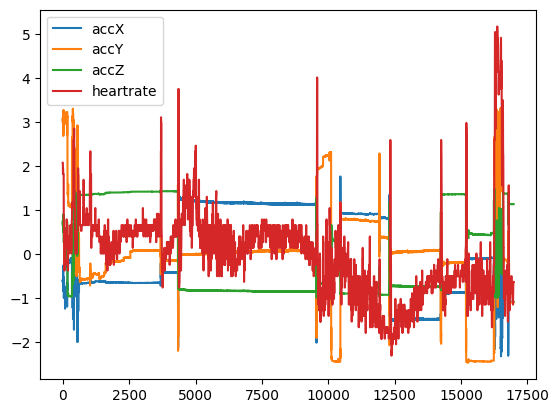

In [378]:
df_feature.plot.line()

<AxesSubplot:>

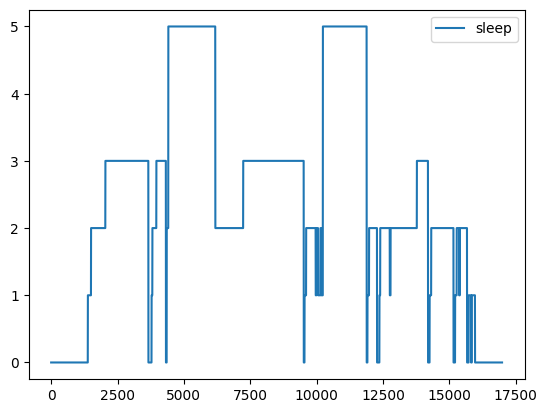

In [379]:
df_label.plot.line()

In [380]:
# ------------ Train-Test-Split 2D features -------------------------------
#X=df_feature
#y=df_label
#seed = 42
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_feature, df_label, test_size=0.3, random_state=42)

In [381]:
# set sliding window parameter
slidingW = 100
Stride_step = 5
n_feature=4
df_feature3D=np.array([],ndmin=2)
df_label_new=np.array([])

for t in range( 0 , len(df_feature), Stride_step ):
    F3d= np.array(df_feature[ t : t + slidingW],ndmin=2)
    if len(F3d)<slidingW:
        break
    F3d.reshape(slidingW, n_feature, 1)
    if df_feature3D.size==0:
        df_feature3D=F3d
    else:
        df_feature3D=np.dstack((df_feature3D,F3d))
    Labels = stats.mode( df_label [ t : t+slidingW ] )
    df_label_new=np.append(df_label_new,Labels[0])

C:\Users\Admin\AppData\Local\Temp\ipykernel_5288\3273889744.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Labels = stats.mode( df_label [ t : t+slidingW ] )


In [382]:
F3d

array([[-1.08121498, -1.09911905,  1.13700377, -0.50104715],
       [-1.08093764, -1.09792365,  1.13793902, -0.50104715],
       [-1.08281078, -1.09874351,  1.13714151, -0.50104715],
       [-1.08311172, -1.09805034,  1.13739179, -0.50104715],
       [-1.08034736, -1.09649515,  1.13830561, -0.50104715],
       [-1.0826026 , -1.09738127,  1.13779902, -0.50104715],
       [-1.08299014, -1.09776666,  1.13724688, -0.50104715],
       [-1.08209192, -1.09651416,  1.13801504, -0.50104715],
       [-1.08216258, -1.09677464,  1.13791832, -0.50104715],
       [-1.08243994, -1.09797627,  1.13671885, -0.50104715],
       [-1.08195894, -1.09773187,  1.13735717, -0.50104715],
       [-1.08120816, -1.09632232,  1.13772863, -0.50104715],
       [-1.08298403, -1.09747939,  1.13714866, -0.50104715],
       [-1.08249694, -1.09793615,  1.13722506, -0.50104715],
       [-1.08089054, -1.09637587,  1.1378852 , -0.50104715],
       [-1.07959642, -1.0963384 ,  1.13828791, -0.50104715],
       [-1.0811109 , -1.

In [383]:
df_feature3D=np.swapaxes(df_feature3D,0,2)
df_feature3D=np.swapaxes(df_feature3D,1,2)
df_feature3D=df_feature3D[...,np.newaxis]
df_feature3D

array([[[[-0.58754699],
         [ 3.05807519],
         [ 0.69872824],
         [ 2.07870531]],

        [[-0.58145574],
         [ 2.99509378],
         [ 0.75774575],
         [ 2.07870531]],

        [[-0.59107524],
         [ 3.02466836],
         [ 0.72269623],
         [ 2.07870531]],

        ...,

        [[-0.92104538],
         [ 3.14574551],
         [ 0.23209668],
         [ 0.27287859]],

        [[-0.91866235],
         [ 3.14714076],
         [ 0.23126907],
         [ 0.27287859]],

        [[-0.90930807],
         [ 3.15256736],
         [ 0.23283358],
         [ 0.27287859]]],


       [[[-0.63079638],
         [ 3.06967162],
         [ 0.66802186],
         [ 1.82073006]],

        [[-0.65623081],
         [ 3.03358303],
         [ 0.6929944 ],
         [ 1.82073006]],

        [[-0.61745949],
         [ 3.04996268],
         [ 0.70392346],
         [ 1.82073006]],

        ...,

        [[-0.92642696],
         [ 3.14347961],
         [ 0.2498879 ],
         [ 0.272

In [384]:
df_label_new

array([0., 0., 0., ..., 0., 0., 0.])

In [385]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_feature, df_label, test_size=0.3, random_state=42)

In [386]:
x3D_train, x3D_test, y3D_train, y3D_test = model_selection.train_test_split( df_feature3D , df_label_new, test_size=0.33, random_state=42)

In [387]:
# ------------ NN Architecture parameter -------------------------------
Hidden_Layer_param = (30, 30, 30)
mlp = MLPClassifier(hidden_layer_sizes = Hidden_Layer_param)
mlp

MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [388]:
mlp.fit(X_train,y_train)
smlp_pred = mlp.predict(X_test)

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [389]:
y_test

sleep
13205    2.0
6393     2.0
608      0.0
4745     5.0
12036    2.0
...      ...
5148     5.0
1369     0.0
740      0.0
5527     5.0
1188     0.0

[5095 rows x 1 columns]

In [390]:
smlp_pred[0]

2.0

In [391]:
print('Confusion Matrix of smlp_pred: ')
print(confusion_matrix(y_test, smlp_pred))
print('Classification Report of smlp_preds: ')
print(classification_report(y_test, smlp_pred))

Confusion Matrix of smlp_pred: 
[[ 753   28   38   29    8]
 [  51  144   38    2   10]
 [  80   57 1247   64   74]
 [   2    1   58 1398    0]
 [   0    2    8    0 1003]]
Classification Report of smlp_preds: 
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86       856
         1.0       0.62      0.59      0.60       245
         2.0       0.90      0.82      0.86      1522
         3.0       0.94      0.96      0.95      1459
         5.0       0.92      0.99      0.95      1013

    accuracy                           0.89      5095
   macro avg       0.84      0.85      0.84      5095
weighted avg       0.89      0.89      0.89      5095



In [392]:
# ------------ CNN Architecture parameter -------------------------------
# Nlayer (CNN, dense), Nnode, Activation
CNN_L1 = 16
CNN_L2 = 64
CNN_L3 = 128
D_L1 = 512
D_out = 6
n_feature = 4
Act_func = "relu"
Ker_size = (3,3)
Pooling_size = (2,1)
Input_shape = (slidingW, n_feature, 1)

In [393]:
# ------------ Create CNN Model -------------------------------
model = models.Sequential()
model.add(layers.Conv2D(CNN_L1, kernel_size=Ker_size, activation=Act_func,input_shape=Input_shape,padding='same'))
model.add(layers.MaxPooling2D(pool_size=Pooling_size))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(CNN_L2, kernel_size=Ker_size, activation= Act_func, padding='same'))
model.add(layers.MaxPooling2D(pool_size= Pooling_size))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(CNN_L3, kernel_size=Ker_size, activation= Act_func,padding='same'))
model.add(layers.MaxPooling2D(pool_size= Pooling_size))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(D_L1 , activation= Act_func ))
model.add(layers.Dense(D_out, activation='sigmoid'))
model.compile(optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 100, 4, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 4, 16)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 50, 4, 16)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 4, 64)         9280      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 4, 64)        0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 25, 4, 64)        

In [394]:
# ------------ Create Optimizer -------------------------------
model.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["acc"])

In [395]:
# ------ Train CNN using 3D feature--------------------------------------------
history = model.fit(x3D_train, y3D_train, epochs=50, batch_size=64,validation_data=(x3D_test, y3D_test))

Epoch 1/50


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 11s 260ms/step - loss: 1.2075 - acc: 0.4912 - val_loss: 0.9515 - val_acc: 0.6072
Epoch 2/50
36/36 [==============================] - 9s 240ms/step - loss: 0.6630 - acc: 0.7210 - val_loss: 0.6667 - val_acc: 0.7220
Epoch 3/50
36/36 [==============================] - 9s 242ms/step - loss: 0.5550 - acc: 0.7653 - val_loss: 0.5780 - val_acc: 0.7677
Epoch 4/50
36/36 [==============================] - 9s 237ms/step - loss: 0.4757 - acc: 0.8042 - val_loss: 0.5124 - val_acc: 0.7910
Epoch 5/50
36/36 [==============================] - 9s 241ms/step - loss: 0.4524 - acc: 0.8073 - val_loss: 0.5126 - val_acc: 0.7695
Epoch 6/50
36/36 [==============================] - 9s 257ms/step - loss: 0.3954 - acc: 0.8307 - val_loss: 0.3975 - val_acc: 0.8439
Epoch 7/50
36/36 [==============================] - 11s 295ms/step - loss: 0.3660 - acc: 0.8501 - val_loss: 0.4010 - val_acc: 0.8260
Epoch 8/50
36/36 [==============================] - 11s 299ms/step - loss: 0.3495 - a

In [396]:
CNN_pred = model.predict(x3D_test)

35/35 [==============================] - 2s 43ms/step


In [397]:
CNN_pred[0]

array([1.0000000e+00, 1.0000000e+00, 1.8463534e-05, 1.5706303e-02,
       1.3583872e-21, 0.0000000e+00], dtype=float32)

In [398]:
y3D_test[0]

0.0

In [399]:
print(utils.multiclass.type_of_target(CNN_pred))

continuous-multioutput


In [400]:
CNN_pred = np.argmax(model.predict(x3D_test),axis=1)

35/35 [==============================] - 2s 40ms/step


In [401]:
print(utils.multiclass.type_of_target(CNN_pred))

multiclass


In [402]:
print('Confusion Matrix of smlp_pred: ')
print(confusion_matrix(y3D_test, CNN_pred))
print('Classification Report of smlp_preds: ')
print(classification_report(y3D_test, CNN_pred))

Confusion Matrix of smlp_pred: 
[[177   1  19   0   0]
 [  1  39  13   0   1]
 [  4   4 323   3  11]
 [  0   0   2 303   0]
 [  0   0   4   0 210]]
Classification Report of smlp_preds: 
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       197
         1.0       0.89      0.72      0.80        54
         2.0       0.89      0.94      0.92       345
         3.0       0.99      0.99      0.99       305
         5.0       0.95      0.98      0.96       214

    accuracy                           0.94      1115
   macro avg       0.94      0.91      0.92      1115
weighted avg       0.94      0.94      0.94      1115



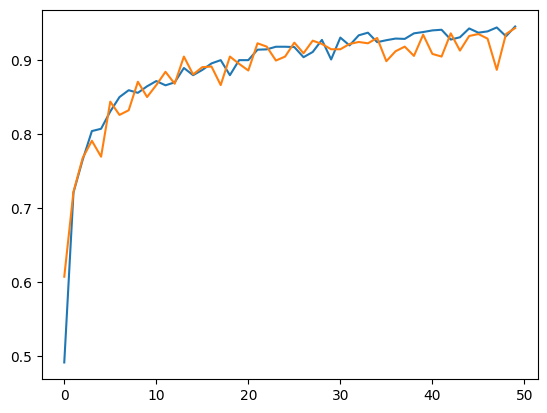

In [403]:
# ------ View History Graph -------------------------------------------
# View Accuracy Graph
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

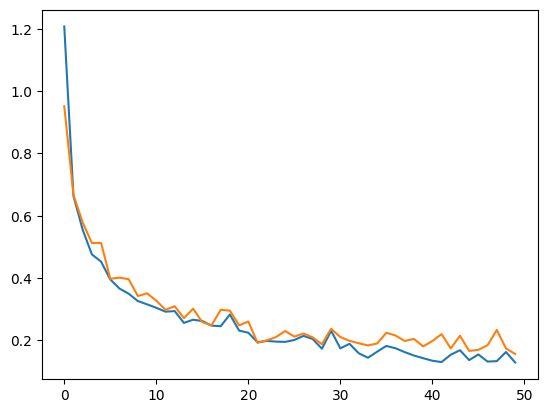

In [404]:
# View Loss Graph
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()